Eastern
Length of timestamp: 1816
Length of filtered O3: 1816


Intercept   -52.481839
PS            0.000545
RH           -0.016737
T             0.066415
WS            0.090757
dtype: float64


Tsuen Wan
Length of timestamp: 1816
Length of filtered O3: 1816


Intercept   -36.421421
PS            0.000408
RH           -0.033908
T             0.048826
WS            0.015893
dtype: float64


Tung Chung
Length of timestamp: 1816
Length of filtered O3: 1816


Intercept   -55.636596
PS            0.000579
RH           -0.017267
T             0.072459
WS           -0.022217
dtype: float64


Yuen Long
Length of timestamp: 1816
Length of filtered O3: 1816


Intercept   -55.841649
PS            0.000588
RH           -0.028743
T             0.084599
WS           -0.007546
dtype: float64


Kwai Chung
Length of timestamp: 1816
Length of filtered O3: 1816


Intercept   -57.789699
PS            0.000615
RH           -0.030257
T             0.043948
WS            0.044611
dtype: float64


Kwun Tong


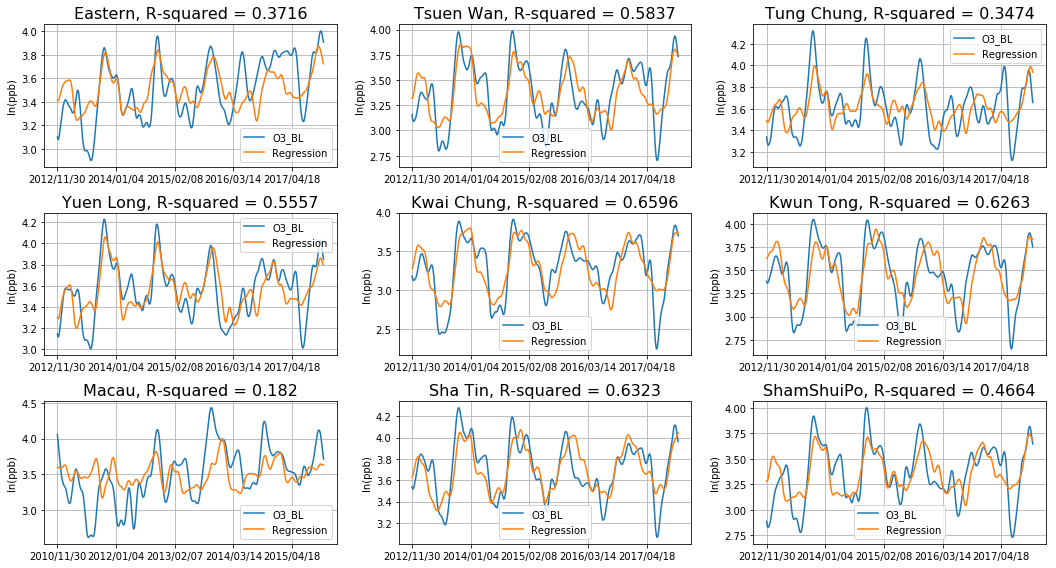

In [10]:
from kolzur_filter import kz_filter, kzft, kzp, _kz_coeffs
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import csv
import os
import math
import matplotlib.pyplot as plt
#import meteorological
import functions
mkz = functions.mkz
ozone = functions.ozone
# For Yuen Long site, work on 2005-2017
# Macau: 2003-2015
# For other four stations, work on 2003-2017
# Tap Mun station is only for detrending, no need to investigate the relationship between the meteorological variables.
subplot_matrix = []
r2 = []
filelist = ['Eastern', 'Tap Mun', 'Tsuen Wan', 'Tung Chung', 'Yuen Long', 'Kwai Chung', 'Kwun Tong', 'Macau', 'Sha Tin', 'ShamShuiPo']


# Find the relationship between variables and O3
def regression(station):
    directory = "preprocessed/"
    if station == 1:  # Tap Mun
        return
    # Import variables
    else:
        df = pd.read_csv(directory + filelist[station] + " data.csv", header=None, low_memory=False)
        values = np.array(df[1:])  # Delete headers
        timestamp = values[:, 0]  # First Column
        pressure = values[:, 1]
        rh = values[:, 2]
        temperature = values[:, 3]
        wind = values[:, 4]
        wd = values[:, 5]

    # Check if there are errors
    header = ["Pressure", "RH", "Temperature", "Wind Speed", "Wind Direction"]
    variables = [pressure, rh, temperature, wind]
    for i in range(len(timestamp)):
        for j in range(len(variables)):
            var = variables[j]
            if float(var[i]) <= 0:
                print("Error", i, j)

    # Convert to daily data
    dailytime = []
    for i in range(len(timestamp)):
        if i % 24 == 0:
            dailytime.append(timestamp[i][:-9])
    pressure = np.array(functions.Daily_two(pressure))  # maximum
    rh = np.array(functions.Daily_two(rh))
    temperature = np.array(functions.Daily_two(temperature))
    wind = np.array(functions.Daily_two(wind))
    wd = np.array(functions.Daily_two(wd))

    # Import O3
    #####
    m = 365
    k = 3
    #####
    timestamp_o3 = ozone(filelist[station], m, k)[0]
    o3 = ozone(filelist[station], m, k)[1]

    # Central, Tung Chung: 2003-2017
    if station == 0 or station == 3:
        time = 0
        year = 0
        while time < len(timestamp_o3) and year < 2003:
            date = timestamp_o3[time]
            year = int(date.split("/")[0])
            time += 1
        timestamp_o3 = timestamp_o3[time-1:]
        o3 = o3[time-1:]

    # Macau: 2003 - 2015
    if station == 7:
        time = 0
        year = 0
        while time < len(timestamp_o3) and year < 2003:
            date = timestamp_o3[time]
            year = int(date.split("/")[0])
            time += 1
        time2 = time
        while time2 < len(timestamp_o3) and year < 2016:
            date = timestamp_o3[time2]
            year = int(date.split("/")[0])
            time2 += 1
        timestamp_o3 = timestamp_o3[time-1:time2-1]
        o3 = o3[time-1:time2-1]

    # Tsuen Wan, Yuen Long, Kwai Chung: 2005-2017
    if station == 2 or station == 4 or station == 5:
        time = 0
        year = 0
        while time < len(timestamp_o3) and year < 2005:
            date = timestamp_o3[time]
            year = int(date.split("/")[0])
            time += 1
        timestamp_o3 = timestamp_o3[time - 1:]
        o3 = o3[time - 1:]

    # Change o3 into ln(o3)
    for integer in range(len(o3)):
        if o3[integer] != 0:
            o3[integer] = math.log(o3[integer])

    # Save the original o3 data
    o3_original = o3

    # KZ(29,3) to create baseline: o3_bl
    m = 29
    k = 3
    o3 = kz_filter(o3, m, k)
    pressure = kz_filter(pressure, m, k)
    rh = kz_filter(rh, m, k)
    temperature = kz_filter(temperature, m, k)
    wind = kz_filter(wind, m, k)
    # wd = kz_filter(wd, m, k)

    # Adjust time
    w = int(k * (m - 1) / 2)
    dailytime = dailytime[w:-w]
    timestamp_o3 = timestamp_o3[w:-w]
    o3_original = o3_original[w:-w]
    wd = wd[w:-w]

    #####
    # Cut 5 years
    t = 1816
    dailytime = dailytime[-t:]
    timestamp_o3 = timestamp_o3[-t:]
    o3 = o3[-t:]
    o3_original = o3_original[-t:]
    pressure = pressure[-t:]
    rh = rh[-t:]
    temperature = temperature[-t:]
    wind = wind[-t:]
    wd = wd[-t:]

    print(filelist[station])
    #print("Variables", dailytime)
    #print("O3", timestamp_o3)
    print("Length of timestamp:", len(timestamp_o3))
    print("Length of filtered O3:", len(o3))
    print("\n")

    # Regression with O3_BL and MET_BL
    # [O3_BL](t) = a0 +ai * MET_BL(t)i + e(t)
    MET = pd.DataFrame({"O3": o3, "PS": pressure,
                       "RH": rh, "T": temperature,
                        "WS": wind})
    result = sm.ols(formula="O3~PS+RH+T+WS", data=MET).fit()
    print(result.params)
    intercept = result.params[0]
    beta_ps = result.params[1]
    beta_rh = result.params[2]
    beta_t = result.params[3]
    beta_ws = result.params[4]
    rsquared = result.rsquared
    r2.append(rsquared)
    #print(result.summary())
    print("\n")

    resultMatrix = [[0 for x in range(len(header) + 9)] for y in range(len(dailytime) + 1)]
    firstrow = resultMatrix[0]
    for i in range(len(firstrow)):
        if i == 0:
            firstrow[i] = ""
        elif i < len(header)+1:
            firstrow[i] = header[i-1]
        elif i == len(header)+1:
            firstrow[i] = "ln(O3)"
        elif i == len(header)+2:
            firstrow[i] = "O3_BL"
        elif i == len(header)+3:
            firstrow[i] = "Y hat"
        elif i == len(header)+4:
            firstrow[i] = "Error"
        elif i == len(header)+5:
            firstrow[i] = "Long Term"
        elif i == len(header)+6:
            firstrow[i] = "delta"
        elif i == len(header)+7:
            firstrow[i] = "Season"
        elif i == len(header)+8:
            firstrow[i] = "Short"
    resultMatrix = np.array(resultMatrix)
    resultMatrix[:, 0][1:] = dailytime
    resultMatrix[:, 1][1:] = pressure
    resultMatrix[:, 2][1:] = rh
    resultMatrix[:, 3][1:] = temperature
    resultMatrix[:, 4][1:] = wind
    resultMatrix[:, 5][1:] = wd
    resultMatrix[:, 6][1:] = o3_original
    resultMatrix[:, 7][1:] = o3
    # Make Predictions
    y_hat = []
    for i in range(len(dailytime)):
        y_hat.append(intercept + beta_ps*pressure[i] + beta_rh*rh[i] + beta_t*temperature[i] + beta_ws*wind[i])
    
    
    
    
    
    
    
    
    # Regression Coefficients
    directory_coefficients = "Regression Coefficients/"
    if not os.path.exists(directory_coefficients):
        os.makedirs(directory_coefficients)
    #matrix =[0 for x in range(5)]
    matrix = [intercept, beta_ps, beta_rh, beta_t, beta_ws]
    # Write csv file of result matrix
    with open(directory_coefficients + filelist[station] + '.csv', "w") as output:
        writer = csv.writer(output, lineterminator='\n')
        writer.writerow(matrix)
    
    
    
    
    
    
    resultMatrix[:, 8][1:] = y_hat
    # Find error
    error = []
    for j in range(len(dailytime)):
        error.append(o3[j]-y_hat[j])
    resultMatrix[:, 9][1:] = error
    error = np.array(error)
    # e(t) = KZ365,3 [e(t)] +delta(t) = [O3LT](t)+delta(t)
    m = 365
    k = 3
    w = int(k * (m - 1) / 2)
    dailytime_long = dailytime[w:-w]
    timestamp_o3_long = timestamp_o3[w:-w]
    long = kz_filter(error, m, k)
    # print("Length of Long:", len(long), len(dailytime_long), len(timestamp_o3_long))
    resultMatrix[:, 10][1:][w:-w] = long
    # delta(t) = e(t) - [O3LT](t)
    delta = []
    for k in range(len(timestamp_o3_long)):
        delta.append(error[k+w]-long[k])
    resultMatrix[:, 11][1:][w:-w] = delta
    # [O3SEASON](t) = a0 + ai * MET_BL(t)i +delta(t)
    season = []
    for l in range(len(timestamp_o3_long)):
        season.append(y_hat[l+w] + delta[l])
    resultMatrix[:, 12][1:][w:-w] = season
    # [O3](t) = [O3BL](t)+[O3ST](t)
    short = []
    for m in range(len(timestamp_o3)):
        short.append(o3_original[m]-o3[m])
    resultMatrix[:, 13][1:] = short

    # Set the directory
    directory = "5 Year Regression Result/"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Plot a graph
    fig = plt.figure()  # Create a figure
    ax = plt.axes()  # Create axis
    ax.grid(True)
    plt.plot(dailytime, o3, label='O3_BL')
    plt.plot(dailytime, y_hat, label='Regression')
    subplot_matrix.append([dailytime, o3, y_hat])
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Set Maximum number of x-axis values to show
    fig.autofmt_xdate()  # Rotate values to see more clearly
    plt.legend(loc='best')
    title = filelist[station] + ', R-squared = ' + str(round(rsquared, 4))
    title2 = "Intercept" + str(intercept) + "PS" + str(beta_ps) + "RH" + str(beta_rh) + "T" + str(beta_t) + "WS" + str(beta_ws)
    plt.title(title)
    plt.ylabel("ln(ppb)")
    fig.savefig(directory + filelist[station] + ".png")
    # plt.show()
    plt.close(fig)


for files in range(len(filelist)):
    regression(files)


# subplot
fig = plt.figure(figsize=(15, 8))
for file in range(len(filelist)):
    titles = filelist[file]
    if file < 1:
        print("\n")
        print(titles, r2[file])
        title = titles + ', R-squared = ' + str(round(r2[file], 4))
        data = subplot_matrix[file]
        ax = plt.subplot(3, 3, file+1)
    elif file != 1:
        print(titles, r2[file-1])
        title = titles + ', R-squared = ' + str(round(r2[file-1], 4))
        data = subplot_matrix[file-1]
        ax = plt.subplot(3, 3, file)
    if file != 1:
        ax.plot(data[0], data[1], label='O3_BL')
        ax.plot(data[0], data[2], label='Regression')
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Set Maximum number of x-axis values to show
        plt.title(title, fontsize=16)
        plt.ylabel('ln(ppb)')
        plt.legend(loc='best')
        ax.grid(True)

plt.tight_layout()
directory = "5 Year Regression Result/"
fig.savefig(directory + '5 Year Combined Subplot.png')
